In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
file_path = "/content/drive/MyDrive/23-1 데이터 분석 공부/딥러닝 파이토치 교과서/토이프로젝트/"
file_name = "한국어_단발성_대화_데이터셋 (2) (1).xlsx"

df = pd.read_excel(file_path + file_name)
df.head()

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38594 entries, 0 to 38593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  38594 non-null  object
 1   Emotion   38594 non-null  object
dtypes: object(2)
memory usage: 603.2+ KB


In [10]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 34.6 MB/s eta 0:00:00


In [11]:
## 테스트

from konlpy.tag import Komoran

komoran = Komoran()
print(komoran.morphs(df["Sentence"][0]))
print(komoran.pos(df["Sentence"][0]))

['언니', '동생', '으로', '부르', '는', '게', '맞', '는', '일', '이', 'ㄴ가요', '.', '.', '?', '?']
[('언니', 'NNG'), ('동생', 'NNG'), ('으로', 'JKB'), ('부르', 'VV'), ('는', 'ETM'), ('게', 'EC'), ('맞', 'VV'), ('는', 'ETM'), ('일', 'NNB'), ('이', 'VCP'), ('ㄴ가요', 'EF'), ('.', 'SF'), ('.', 'SF'), ('?', 'SF'), ('?', 'SF')]


In [12]:
## 감정 종류

df["Emotion"].unique()

array(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'], dtype=object)

In [13]:
## 오... 행복이 생각보다 너무 적네요...
## 놀람, 중립은 긍정/부정을 학습하기 애매하므로 우선 제외시키겠습니다.

df = df[(df["Emotion"] != '놀람')]
df = df[(df["Emotion"] != '중립')]
df["Emotion"].unique()

array(['공포', '분노', '슬픔', '행복', '혐오'], dtype=object)

In [14]:
def change_dummies(s):
  return 1 if s == "행복" else 0


df["emotion_dummies"] = df["Emotion"].apply(change_dummies)
df.head()

<ipython-input-14-77dc5ea11b61>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["emotion_dummies"] = df["Emotion"].apply(change_dummies)


,Sentence,Emotion,emotion_dummies
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,0
1,그냥 내 느낌일뿐겠지?,공포,0
2,아직너무초기라서 그런거죠?,공포,0
3,유치원버스 사고 낫다던데,공포,0
4,근데 원래이런거맞나요,공포,0


In [15]:
df[df["emotion_dummies"] == 0].count()
df[df["emotion_dummies"] == 1].count()

## 개수가 4배 이상 차이나네요..
## 수치형 데이터도 아니고 단순 문자열 데이터라 언더샘플링을 사용해도 되는지 의문입니다.

Sentence           6037
Emotion            6037
emotion_dummies    6037
dtype: int64

In [16]:
## 자연어 전처리 : 기본 정제 및 공백 기준으로 배열화

## 정규 표현식을 이용해 한글과 공백만 빼고 나머지 제외

def text_preprocessor(s):
    import re
    
    ## (1) [], (), {}, <> 괄호와 괄호 안 문자 제거하기
    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\[[^)]*\]'  # []
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\<[^)]*\>'  # <>
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\{[^)]*\}'  # {}
    s = re.sub(pattern=pattern, repl='', string=s)
    
    ## (2) '...외', '...총' 제거하기
    s = s.replace('...외', ' ')
    s = s.replace('...총', ' ')
    
    ## (3) 특수문자 제거
    pattern = r'[^a-zA-Z가-힣]'
    s = re.sub(pattern=pattern, repl=' ', string=s)
    
    ## (4) 단위 제거: cm, km, etc.
    units = ['mm', 'cm', 'km', 'ml', 'kg', 'g']
    for unit in units:
        s = s.lower() # 대문자를 소문자로 변환
        s = s.replace(unit, '')
        
    # (5) 공백 기준으로 분할하기
    s_split = s.split()
    
    # (6) 글자 1개만 있으면 제외하기
    s_list = []
    for word in s_split:
        if len(word) !=1:
            s_list.append(word)
            
    return s_list

df['sentence_list'] = df['Sentence'].apply(lambda s: text_preprocessor(s))

df.head()

,Sentence,Emotion,emotion_dummies,sentence_list
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,0,"[언니, 동생으로, 부르는게, 맞는, 일인가요]"
1,그냥 내 느낌일뿐겠지?,공포,0,"[그냥, 느낌일뿐겠지]"
2,아직너무초기라서 그런거죠?,공포,0,"[아직너무초기라서, 그런거죠]"
3,유치원버스 사고 낫다던데,공포,0,"[유치원버스, 사고, 낫다던데]"
4,근데 원래이런거맞나요,공포,0,"[근데, 원래이런거맞나요]"


In [17]:
## 자연어 전처리 : 토큰화

from konlpy.tag import Kkma

def words_tokonizer(text):
    from konlpy.tag import Kkma # NLP of the Korean language
    kkma = Kkma()
    
    words = []
    
    # Text preprocessing using the UDF above
    s_list = text_preprocessor(text)
    
    # POS tagging
    for s in s_list:
        words_ = kkma.pos(s)   
        
        # NNG indexing
        for word in words_:
            if (word[1] == 'NNG') or (word[1] == 'NNP') :
                words.append(word[0])
            elif (word[1] == 'VA') or (word[1] == 'VV') :
                words.append(word[0] +'다')
            
    return words

df['sentence_list'] = df['Sentence'].apply(lambda text: words_tokonizer(text))

In [18]:
df.head(10)

,Sentence,Emotion,emotion_dummies,sentence_list
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,0,"[언니, 동생, 부르다, 맞다, 일]"
1,그냥 내 느낌일뿐겠지?,공포,0,[느낌]
2,아직너무초기라서 그런거죠?,공포,0,"[초기, 그러다]"
3,유치원버스 사고 낫다던데,공포,0,"[유치원, 버스, 사고, 낫다, 덜다]"
4,근데 원래이런거맞나요,공포,0,"[이러다, 맞다]"
5,남자친구가 떠날까봐요,공포,0,"[남자, 친구, 떠나다]"
6,이거 했는데 허리가 아플수도 있나요? ;;,공포,0,"[하다, 허리, 아프다, 있다]"
7,내가불안해서꾸는걸까..,공포,0,"[내가, 불안, 꾸다, 깔다]"
8,일주일도 안 남았당...ㅠㅠ,공포,0,"[일주일, 남다]"
9,약은 최대한 안먹으려고 하는데좋은 음시있나요?0,공포,0,"[약, 최대한, 먹다, 하다, 좋다, 음시, 있다]"


In [28]:
## 자연어 전처리 : 불용어 제거

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓"
## 구글에서 한국어 불용어 처리에 주로 활용되는 단어들을 긁어옴. 여기에 해당되는 단어는 제거
## 걱정되는 부분은 배열의 길이가 너무 길어 in 문법으로 순회하는 게 너무 비효율적일 거 같다는 느낌

stop_words=stop_words.split(' ')

def del_stop_words(seq):
  result = [] 
  for w in seq: 
      if w not in stop_words: 
        if len(w) != 1:
          result.append(w)
  return result  

df["sentence_list"] = df["sentence_list"].apply(lambda seq: del_stop_words(seq))
df.head()

,Sentence,Emotion,emotion_dummies,sentence_list
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,0,"[언니, 동생, 부르다, 맞다]"
1,그냥 내 느낌일뿐겠지?,공포,0,[느낌]
2,아직너무초기라서 그런거죠?,공포,0,"[초기, 그러다]"
3,유치원버스 사고 낫다던데,공포,0,"[유치원, 버스, 사고, 덜다]"
4,근데 원래이런거맞나요,공포,0,"[이러다, 맞다]"


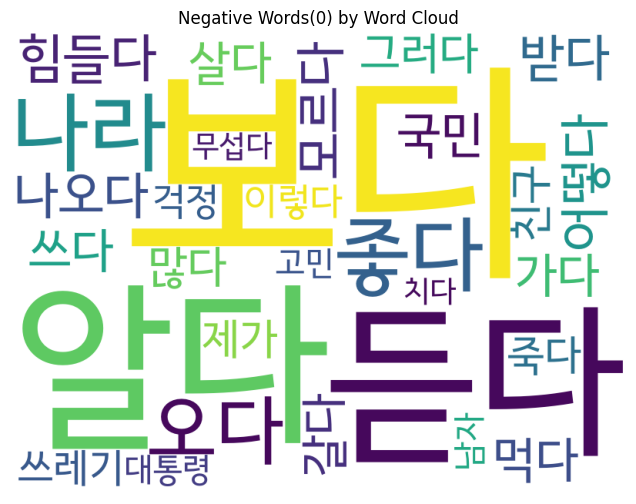

In [20]:
## word cloud

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_list_0 = []

emotion_0 = df[df["emotion_dummies"] == 0]["sentence_list"]

for seq in emotion_0:
  for w in seq:
    all_list_0.append(w)

counts = Counter(all_list_0)
tags = counts.most_common(30)

wc = WordCloud(font_path='/content/drive/MyDrive/23-1 데이터 분석 공부/딥러닝 파이토치 교과서/토이프로젝트/KakaoOTFRegular.otf', background_color='white', width=800, height=600)
cloud = wc.generate_from_frequencies(dict(tags))

plt.figure(figsize=(8, 6))
plt.title('Negative Words(0) by Word Cloud')
plt.axis('off')
plt.imshow(cloud)
plt.show()


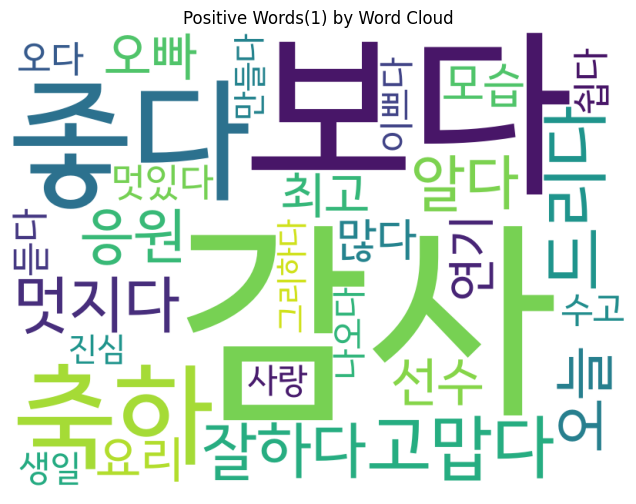

In [21]:
## word cloud

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_list_1 = []

emotion_1 = df[df["emotion_dummies"] == 1]["sentence_list"]

for seq in emotion_1:
  for w in seq:
    all_list_1.append(w)

counts = Counter(all_list_1)
tags = counts.most_common(30)

wc = WordCloud(font_path='/content/drive/MyDrive/23-1 데이터 분석 공부/딥러닝 파이토치 교과서/토이프로젝트/KakaoOTFRegular.otf', background_color='white', width=800, height=600)
cloud = wc.generate_from_frequencies(dict(tags))
plt.figure(figsize=(8, 6))
plt.title('Positive Words(1) by Word Cloud')
plt.axis('off')
plt.imshow(cloud)
plt.show()


In [83]:
## 자연어 전처리 : 정수 인코딩 (FreqDist)

from nltk import FreqDist
import numpy as np

vocab = FreqDist(np.hstack(df["sentence_list"]))
vocab

FreqDist({'보다': 1742, '좋다': 959, '알다': 783, '듣다': 708, '오다': 577, '나라': 555, '나오다': 534, '감사': 525, '받다': 522, '힘들다': 508, ...})

In [84]:
## 상위 10000개의 단어만 단어 집합으로 저장 예
vocab_size = 10000

## 상위 500의 단어만 보존
vocab = vocab.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab)))
print(vocab[:10]) # 단어 집합 10개만 내용 확인('단어', 빈도수)

단어 집합의 크기 : 10000
[('보다', 1742), ('좋다', 959), ('알다', 783), ('듣다', 708), ('오다', 577), ('나라', 555), ('나오다', 534), ('감사', 525), ('받다', 522), ('힘들다', 508)]


In [43]:
word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}
word_to_index['pad'] = 1 # 패딩용 인덱스 1
word_to_index['unk'] = 0 # unknown 용 인덱스 0


## 기존 훈련 데이터에서 각 단어를 고유한 정수로 부여
encoded = []
for line in df["sentence_list"]: #입력 데이터에서 1줄씩 문장을 읽음
    temp = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      try:
        temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
      except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
        temp.append(word_to_index['unk']) # unk의 인덱스로 변환

    encoded.append(temp)

encoded[:10]

[[351, 713, 486, 37],
 [270],
 [1923, 21],
 [1521, 766, 207, 142],
 [57, 37],
 [26, 24, 336],
 [940, 60],
 [539, 110, 999, 234],
 [427, 113],
 [0, 17, 3, 0]]

문장의 최대 길이 : 75
문장의 최소 길이 : 0
문장의 평균 길이 : 3.953599


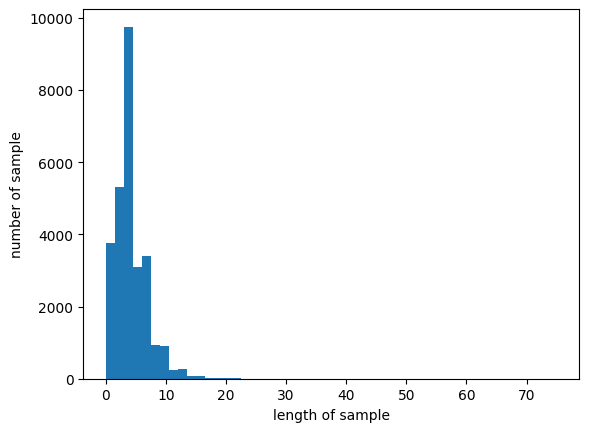

In [44]:
## 정해줄 길이를 찾기 위해 가장 긴 리뷰 길이 확인

max_len = max(len(l) for l in encoded)
print('문장의 최대 길이 : %d' % max_len)
print('문장의 최소 길이 : %d' % min(len(l) for l in encoded))
print('문장의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))
plt.hist([len(s) for s in encoded], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [45]:
## 모든 리뷰의 길이 통일
for line in encoded:
    if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
        line += [word_to_index['pad']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.

print('문장의 최대 길이 : %d' % max(len(l) for l in encoded))
print('문장의 최소 길이 : %d' % min(len(l) for l in encoded))
print('문장의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))

문장의 최대 길이 : 75
문장의 최소 길이 : 75
문장의 평균 길이 : 75.000000


In [39]:
## 모델 생성

# Word2Vec으로 벡터화
from gensim.models import Word2Vec

model = Word2Vec(sentences = df["sentence_list"], vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
model.wv.vectors.shape

(3529, 100)

In [92]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

def create_model():
    model = keras.Sequential()
    model.add(layers.Embedding(10000, 500, input_length=75))
    model.add(layers.Bidirectional(layers.LSTM(100, activation='relu')))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(20))
    model.add(layers.Dense(1, activation='softmax'))
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                 metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 75, 500)           5000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 200)              480800    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 50)                10050     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 20)                1020      
                                                                 
 dense_17 (Dense)            (None, 1)                 21        
                                                      

In [90]:
# print(len(encoded))
# print(len(df['emotion_dummies']))

y = list(df["emotion_dummies"])

train_X, test_X, train_Y, test_Y = train_test_split(encoded, y, test_size=0.3, random_state=321)
train_X = np.array(train_X)
test_X = np.array(test_X)
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(19506, 75)
(8360, 75)
(19506,)
(8360,)


In [93]:
history = model.fit(train_X, train_Y, shuffle=True ,epochs=4, batch_size=100, 
                   validation_data=(train_X, train_Y)
                   )

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


196/196 [==============================] - 204s 970ms/step - loss: nan - accuracy: 0.6287 - val_loss: nan - val_accuracy: 0.7828
Epoch 2/4
196/196 [==============================] - 186s 950ms/step - loss: nan - accuracy: 0.7828 - val_loss: nan - val_accuracy: 0.7828
Epoch 3/4
196/196 [==============================] - 185s 947ms/step - loss: nan - accuracy: 0.7828 - val_loss: nan - val_accuracy: 0.7828
Epoch 4/4
196/196 [==============================] - 188s 960ms/step - loss: nan - accuracy: 0.7828 - val_loss: nan - val_accuracy: 0.7828


In [94]:
model.save('chatbot_model.h5')

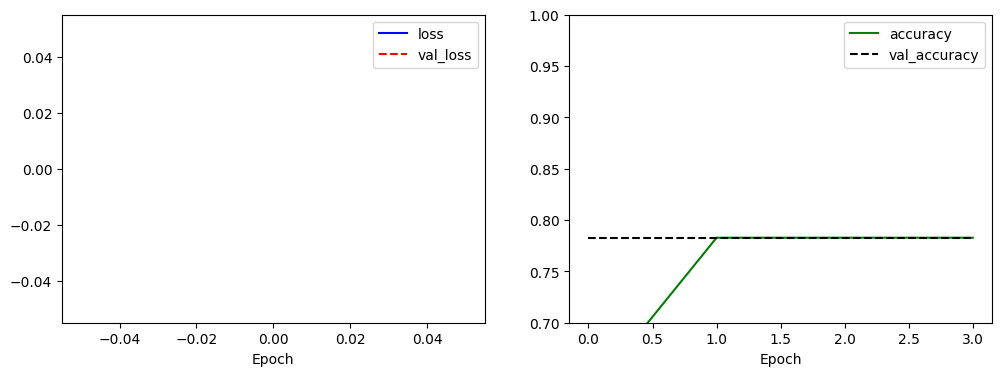

In [95]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [96]:
result_emotion = {0: "부정", 1:"긍정"}

In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)

test_sentence = input("하고싶은 말을 하세요: ")
test_sentence = test_sentence.split(' ')
test_sentences = []
now_sentence = []
for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=75)
prediction = model.predict(test_X_1)
for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])
    result = prediction[idx]
    res_ind = np.argmax(result)
print("감정분석 결과: ", result_emotion[res_ind])

하고싶은 말을 하세요: 대통령 보다 좋다 오빠 오다
1/1 [==============================] - 0s 64ms/step
['대통령']
[nan]
['대통령', '보다']
[nan]
['대통령', '보다', '좋다']
[nan]
['대통령', '보다', '좋다', '오빠']
[nan]
['대통령', '보다', '좋다', '오빠', '오다']
[nan]
감정분석 결과:  부정
